In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from keras.utils import plot_model

In [2]:
train_dir = 'train/'
test_dir = 'test/'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


<AxesSubplot:>

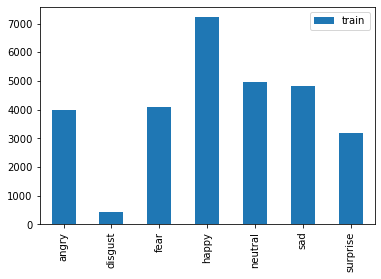

In [3]:
train_count.transpose().plot(kind='bar')

<AxesSubplot:>

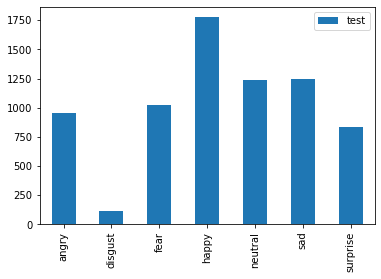

In [4]:
test_count.transpose().plot(kind='bar')

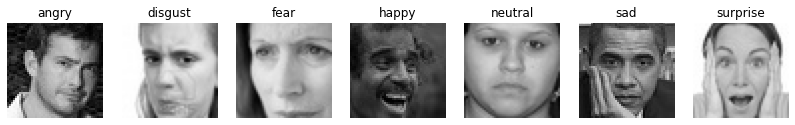

In [5]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [8]:
def get_model(input_size, classes=7):
     #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [9]:
fernet = get_model((row,col,1), classes)
fernet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

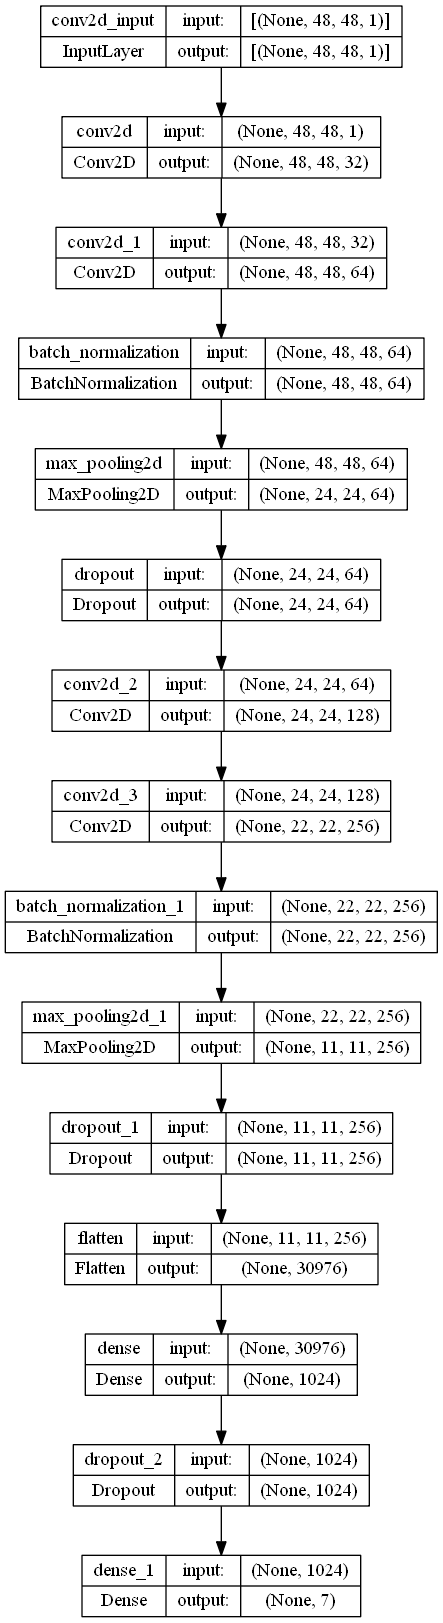

In [10]:
plot_model(fernet, to_file='fernet.png', show_shapes=True, show_layer_names=True)

In [11]:
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [12]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/60
448/448 [==============================] - ETA: 0s - loss: 4.3059 - accuracy: 0.2776
Epoch 1: val_loss improved from inf to 6.29392, saving model to ferNet.h5
448/448 [==============================] - 223s 495ms/step - loss: 4.3059 - accuracy: 0.2776 - val_loss: 6.2939 - val_accuracy: 0.2081 - lr: 1.0000e-04
Epoch 2/60
448/448 [==============================] - ETA: 0s - loss: 3.4863 - accuracy: 0.3332
Epoch 2: val_loss improved from 6.29392 to 3.14772, saving model to ferNet.h5
448/448 [==============================] - 221s 493ms/step - loss: 3.4863 - accuracy: 0.3332 - val_loss: 3.1477 - val_accuracy: 0.3887 - lr: 1.0000e-04
Epoch 3/60
448/448 [==============================] - ETA: 0s - loss: 2.9654 - accuracy: 0.3701
Epoch 3: val_loss improved from 3.14772 to 2.61859, saving model to ferNet.h5
448/448 [==============================] - 245s 546ms/step - loss: 2.9654 - accuracy: 0.3701 - val_loss: 2.6186 - val_accuracy: 0.4420 - lr: 1.0000e-04
Epoch 4/60
448/448 [======

Epoch 27/60
448/448 [==============================] - ETA: 0s - loss: 0.9170 - accuracy: 0.6937
Epoch 27: val_loss did not improve from 1.10138
448/448 [==============================] - 216s 482ms/step - loss: 0.9170 - accuracy: 0.6937 - val_loss: 1.1072 - val_accuracy: 0.6313 - lr: 1.0000e-04
Epoch 28/60
448/448 [==============================] - ETA: 0s - loss: 0.8964 - accuracy: 0.7050
Epoch 28: val_loss did not improve from 1.10138
448/448 [==============================] - 217s 485ms/step - loss: 0.8964 - accuracy: 0.7050 - val_loss: 1.1465 - val_accuracy: 0.6295 - lr: 1.0000e-04
Epoch 29/60
448/448 [==============================] - ETA: 0s - loss: 0.8781 - accuracy: 0.7095
Epoch 29: val_loss did not improve from 1.10138
448/448 [==============================] - 216s 483ms/step - loss: 0.8781 - accuracy: 0.7095 - val_loss: 1.1110 - val_accuracy: 0.6427 - lr: 1.0000e-04
Epoch 30/60
448/448 [==============================] - ETA: 0s - loss: 0.8664 - accuracy: 0.7128
Epoch 30: va

Epoch 54/60
448/448 [==============================] - ETA: 0s - loss: 0.5879 - accuracy: 0.8140
Epoch 54: val_loss did not improve from 1.08700
448/448 [==============================] - 217s 484ms/step - loss: 0.5879 - accuracy: 0.8140 - val_loss: 1.1100 - val_accuracy: 0.6674 - lr: 4.0000e-06
Epoch 55/60
448/448 [==============================] - ETA: 0s - loss: 0.5833 - accuracy: 0.8175
Epoch 55: val_loss did not improve from 1.08700
448/448 [==============================] - 217s 484ms/step - loss: 0.5833 - accuracy: 0.8175 - val_loss: 1.1207 - val_accuracy: 0.6677 - lr: 4.0000e-06
Epoch 56/60
448/448 [==============================] - ETA: 0s - loss: 0.5817 - accuracy: 0.8175
Epoch 56: val_loss did not improve from 1.08700

Epoch 56: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.
448/448 [==============================] - 217s 484ms/step - loss: 0.5817 - accuracy: 0.8175 - val_loss: 1.1165 - val_accuracy: 0.6666 - lr: 4.0000e-06
Epoch 57/60
448/448 [==========

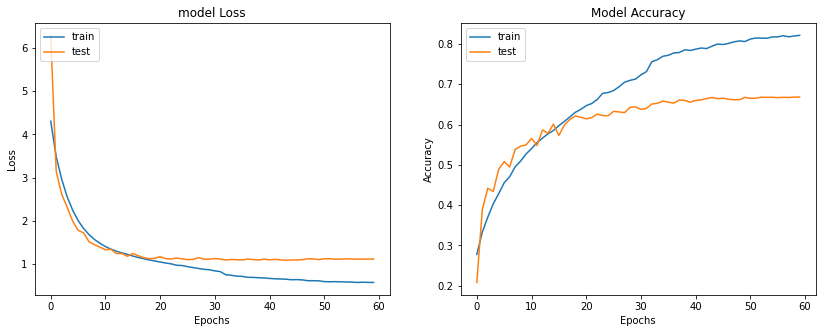

In [13]:
#plotelo de accuracy y loss
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
#evaluación del modelo
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 9s 83ms/step - loss: 1.1149 - accuracy: 0.6682
final train accuracy = 89.69 , validation accuracy = 66.82


In [15]:
fernet.save_weights('fernet_bestweight.h5')

449/449 [==============================] - 37s 83ms/step
Confusion Matrix
[[ 538   53  560 1029  717  645  453]
 [  47    5   56  126   84   69   49]
 [ 576   49  503 1088  789  649  443]
 [1000  102  918 1870 1317 1238  770]
 [ 660   74  716 1237  846  840  592]
 [ 659   78  651 1197  889  801  555]
 [ 441   37  415  809  574  562  333]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.13      0.14      3995
     disgust       0.01      0.01      0.01       436
        fear       0.13      0.12      0.13      4097
       happy       0.25      0.26      0.26      7215
     neutral       0.16      0.17      0.17      4965
         sad       0.17      0.17      0.17      4830
    surprise       0.10      0.11      0.10      3171

    accuracy                           0.17     28709
   macro avg       0.14      0.14      0.14     28709
weighted avg       0.17      0.17      0.17     28709



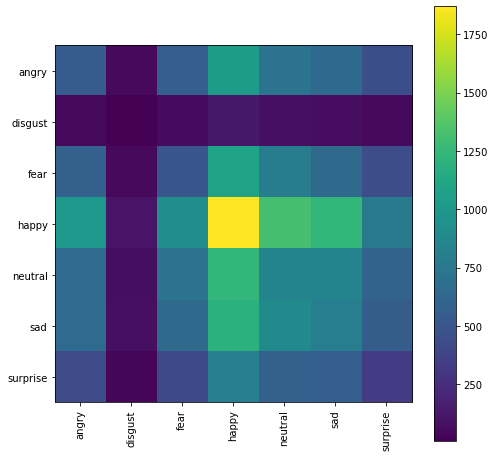

In [16]:
#matriz de confusión y clasificación del training set
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

113/113 [==============================] - 9s 81ms/step
Confusion Matrix
[[145   6 121 232 188 164 102]
 [ 15   1  24  23  15  22  11]
 [175   9 106 265 182 174 113]
 [249  14 214 444 341 315 197]
 [163  13 141 299 247 229 141]
 [173  13 127 303 235 223 173]
 [126  13 106 191 154 139 102]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.15      0.14       958
     disgust       0.01      0.01      0.01       111
        fear       0.13      0.10      0.11      1024
       happy       0.25      0.25      0.25      1774
     neutral       0.18      0.20      0.19      1233
         sad       0.18      0.18      0.18      1247
    surprise       0.12      0.12      0.12       831

    accuracy                           0.18      7178
   macro avg       0.14      0.15      0.14      7178
weighted avg       0.18      0.18      0.18      7178



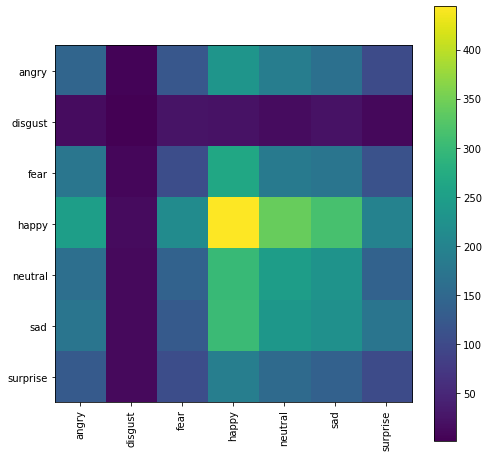

In [17]:
#matriz de confusión y clasificación del test set
y_pred = fernet.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)